In [1]:
import os
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
from itertools import combinations

In [2]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'damages','county')

ppt_products=['chirps','cpc','imerg','prism']
tws_products=['grace-csr','grace-jpl','clsm-grace']

In [4]:
def select(ts,m):
    if np.isnan(m):
        return np.nan
    else:
        return ts[int(m)-1]
    
out = []
for ppt_product in ppt_products:
    for tws_product in tws_products:
        clim_mon = xr.open_dataset(os.path.join(project_dir,'data','processed','excess_precip_stats_mon','county',f'{ppt_product}_{tws_product}_mon.nc'))
        clim_mon['county'] = clim_mon['county'].astype(int)
        if 'rain' not in ppt_product:
            clim_mon = clim_mon.rename({"ppt":"rain"})

        # clim_mon['rain_anom'] = clim_mon['rain'].groupby("time.month").map(lambda x: (x-x.mean('time')))
        clim_mon['tws_anom_mon'] = clim_mon['tws_def_ant'].groupby("time.month").map(lambda x: (x-x.mean('time')))
        clim_mon['tws_anom_all'] = clim_mon['tws_def_ant']-clim_mon['tws_def_ant'].mean("time")

        pexc_max_mo = clim_mon.groupby("time.year").apply(lambda g: g['p_exc'].idxmax("time").dt.month)
        tws_anom_pexcmax = xr.apply_ufunc(select,
                                          clim_mon['tws_anom_mon'].groupby("time.year"),
                                          pexc_max_mo,
                                          input_core_dims=[['time'],[]],
                                          vectorize=True)
        coef = pd.read_csv(os.path.join(project_dir,'data','processed','damage_func_coefs',f'{ppt_product}_{tws_product}','county_se','lag1.csv')).set_index('Coefficient')
        coef_ds = xr.Dataset.from_dataframe(coef.transpose())

        me_obs = coef_ds['p_exc_rxmon']+2*clim_mon['p_exc'].groupby("time.year").max()*coef_ds['p_exc_rxmon_sq']
        tws_anom_flood = tws_anom_pexcmax.where(me_obs<0)
        
        flood_count = tws_anom_flood.count(['year','index'])
        flood_count.name = 'n_flood'
        
        neg_anom_count = (tws_anom_flood<0).sum(['year','index'])
        neg_anom_count.name = 'n_flood_neg_def'
        
        merged = xr.merge([flood_count,neg_anom_count]).assign_coords(product=f'{ppt_product}_{tws_product}')
        out.append(merged)
        print(ppt_product,tws_product)
out = xr.concat(out,dim='product')
out['neg_anom_frac'] = out['n_flood_neg_def']/out['n_flood']
tws_anom_frac_df = gdf.merge(out.mean('product').to_dataframe().reset_index(),on='county')

chirps grace-csr
chirps grace-jpl
chirps clsm-grace
cpc grace-csr
cpc grace-jpl
cpc clsm-grace
imerg grace-csr
imerg grace-jpl
imerg clsm-grace
prism grace-csr
prism grace-jpl
prism clsm-grace


In [6]:
gdf = gpd.read_file(os.path.join(project_dir,'data','interim','cnty_bnds_fixed'))

In [ ]:
out

<Axes: >

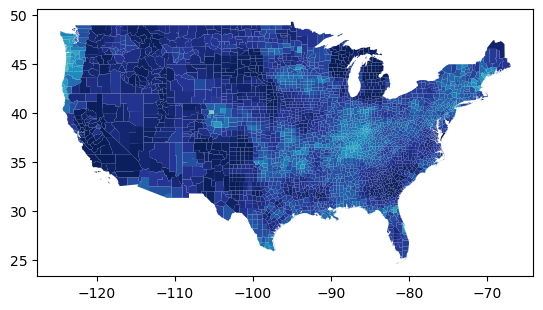

In [8]:
tws_anom_frac_df.plot(column='neg_anom_frac',vmin=0,vmax=1,cmap='YlGnBu')

In [9]:
(tws_anom_flood<0).sum()/tws_anom_flood.count()

<xarray.DataArray ()> Size: 8B
array(0.84452934)
Coordinates:
    spatial_ref  int64 8B 0